In [3]:
!pip install pandas matplotlib seaborn xeus-python ipykernel 

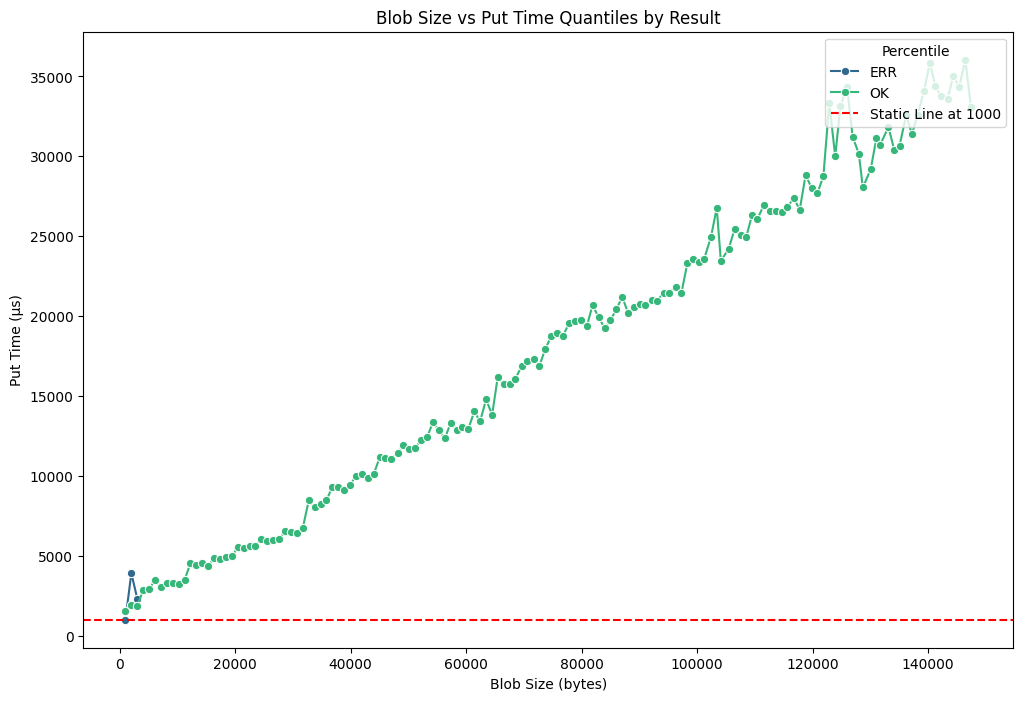

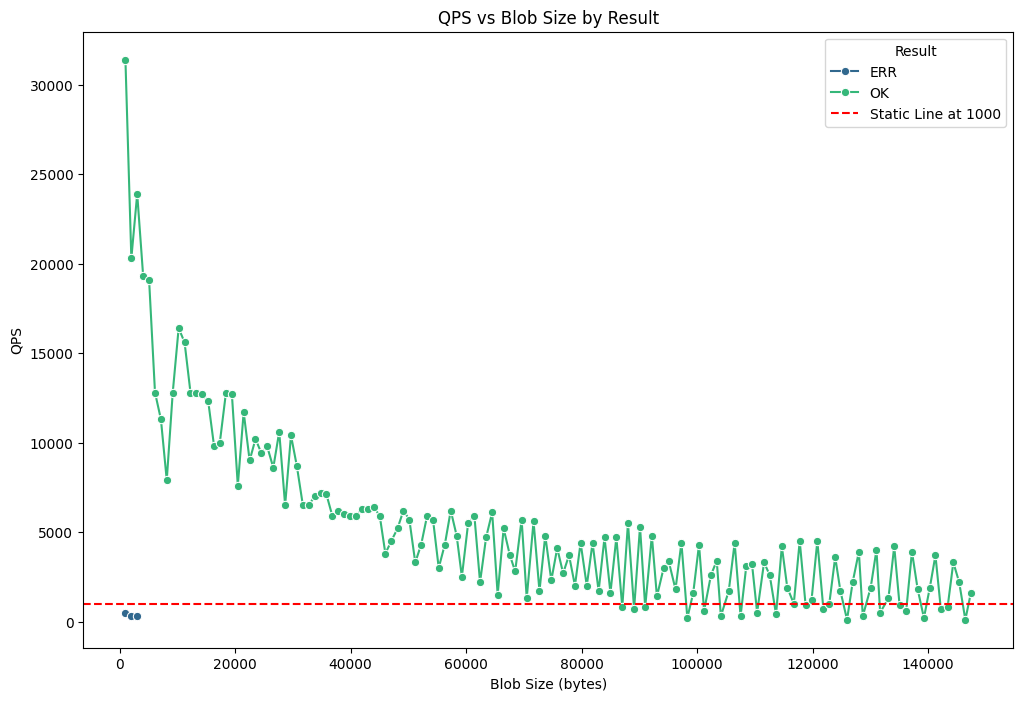

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data from text file
with open('logs_utf8.txt', 'r', encoding='utf-8', errors='replace') as file:
    lines = file.readlines()

# Convert data to a list of dictionaries
data_list = []
for line in lines:
    if not line.startswith("Err"):
        items = line.strip().split(',')
        entry = {item.split(':')[0]: item.split(':')[1] for item in items}
        data_list.append(entry)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data_list)

# Convert columns to appropriate data types
df['EpochTime'] = df['EpochTime'].astype(int)
df['Thread'] = df['Thread'].astype(int)
df['Count'] = df['Count'].astype(int)
df['BlobSize'] = df['BlobSize'].astype(int)
df['PutTimeMicroseconds'] = df['PutTimeMicroseconds'].astype(int)

# Aggregate data by EpochTime and Result
agg_df = df.groupby(['EpochTime', 'Result']).agg({
    'Count': 'count',
    'BlobSize': 'mean'
}).reset_index()

# Calculate quantiles for PutTimeMicroseconds
quantiles = df.groupby(['EpochTime', 'Result'])['PutTimeMicroseconds'].quantile([0.25, 0.50, 0.75]).unstack().reset_index()
quantiles.columns = ['EpochTime', 'Result', 'Quantile_25', 'Quantile_50', 'Quantile_75']

# Merge quantiles back to aggregated dataframe
agg_df = pd.merge(agg_df, quantiles, on=['EpochTime', 'Result'])

# Calculate QPS using the median (50th quantile)
agg_df['QPS'] = agg_df['Count'] *100

# Plotting all quantiles on the same graph
plt.figure(figsize=(12, 8))
sns.lineplot(data=agg_df, x='BlobSize', y='Quantile_25', hue='Result', palette='viridis', marker='o')
plt.axhline(y=1000, color='red', linestyle='--', label='Static Line at 1000')  # Adding static line at 1000
plt.title('Blob Size vs Put Time Quantiles by Result')
plt.xlabel('Blob Size (bytes)')
plt.ylabel('Put Time (µs)')
plt.legend(title='Percentile', loc='upper right')
plt.ticklabel_format(style='plain', axis='y')  # Ensures the y-axis shows full decimals
plt.show()

# Plot QPS vs Blob Size by Result
plt.figure(figsize=(12, 8))
sns.lineplot(data=agg_df, x='BlobSize', y='QPS', hue='Result', palette='viridis', marker='o')
plt.axhline(y=1000, color='red', linestyle='--', label='Static Line at 1000')  # Adding static line at 1000
plt.title('QPS vs Blob Size by Result')
plt.xlabel('Blob Size (bytes)')
plt.ylabel('QPS')
plt.legend(title='Result')
plt.ticklabel_format(style='plain', axis='y')  # Ensures the y-axis shows full decimals
plt.show()
